In [2]:
import pandas as pd

for i in range(1, 7):
    input = f'D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc{i}.csv'
    dataset2= "C:/thesis/climate_bike/bike_updated_MRT.csv"
    output =  f'D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc{i}_new2.csv'
    # Load the CSVs
    df1 = pd.read_csv(input)   # Main dataset
    df2 = pd.read_csv(dataset2)  # Additional data

    join_cols = ['latitude', 'longitude', 'Air_Temp', 'humidity', 'Qs_in']

    columns_to_add = {
        'MRT_C': 'new_MRT_C',
        'direction_raw': 'direction_raw',
        'stationary': 'stationary',
        'direction': 'direction',
        'cardinal_aligned': 'cardinal_aligned'
    }

    # Keep join columns in selection
    df2_subset = df2[join_cols + list(columns_to_add.keys())].copy()
    df2_subset = df2_subset.rename(columns=columns_to_add)

    # Merge using multiple keys
    merged = pd.merge(df1, df2_subset, on=join_cols, how='left')

    def is_near_cardinal(direction, tolerance=10):
        cardinals = [0, 90, 180, 270, 360]
        return any(min(abs(direction - c), 360 - abs(direction - c)) <= tolerance for c in cardinals)

    # Apply to the interpolated direction column
    merged['cardinal_aligned_10'] = merged['direction'].apply(is_near_cardinal)


    # Save to CSV
    merged.to_csv(output, index=False)

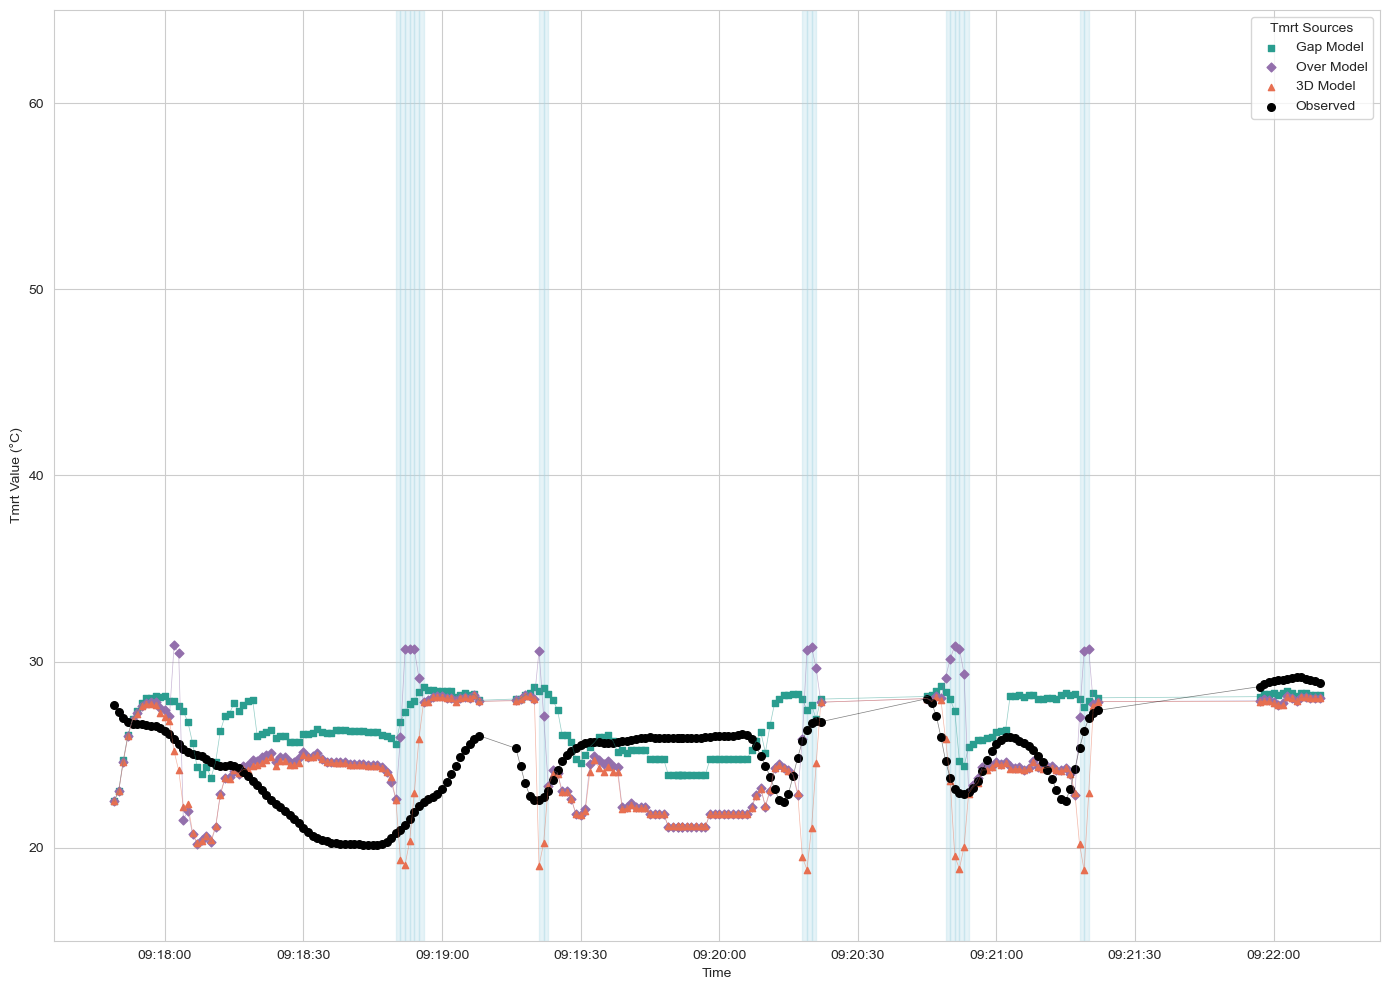

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

test_file = ("D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new.csv")
df = pd.read_csv(test_file)


# Convert 'under' to boolean
df['under'] = df['under'].astype(str).str.upper() == 'TRUE'

# Convert timestamp if available
if 'TIMESTAMP' in df.columns:
    df['timestamp'] = pd.to_datetime(df['TIMESTAMP'])
    x_col = 'timestamp'
else:
    df['Row'] = df.index
    x_col = 'Row'

# Plot setup
plt.figure(figsize=(14, 10))

# Shade background where under == True
for i in range(len(df)-1):
    if df.loc[i, 'under']:
        plt.axvspan(df.loc[i, x_col], df.loc[i+1, x_col], color='lightblue', alpha=0.3)



# Define colors and markers for the other columns
tmrt_models = {
    'gap1': ('#2a9d8f', 's', 'Gap Model'),
    'over1': ('#936fac', 'D', 'Over Model'),
    '3d1': ('#e76f51', '^', '3D Model')
}

# Plot each modeled TMRT as unconnected points
for col, (color, marker, custom_label) in tmrt_models.items():
    if col in df.columns:
        plt.scatter(df[x_col], df[col], color=color, label=custom_label, marker=marker, s=20)
        plt.plot(df[x_col], df[col], color=color, linewidth=0.5, alpha=0.5)

plt.scatter(df[x_col], df['new_MRT_C'], color='black', label='Observed', marker='o', s=30)
# Add lines connecting the observed points as well
plt.plot(df[x_col], df['new_MRT_C'], color='black', linewidth=0.5, alpha=0.5)

plt.ylim(15, 65)

plt.xlabel("Time" if x_col == 'timestamp' else "Row Index")
plt.ylabel("Tmrt Value (°C)")
plt.legend(title='Tmrt Sources')
plt.tight_layout()
plt.show()

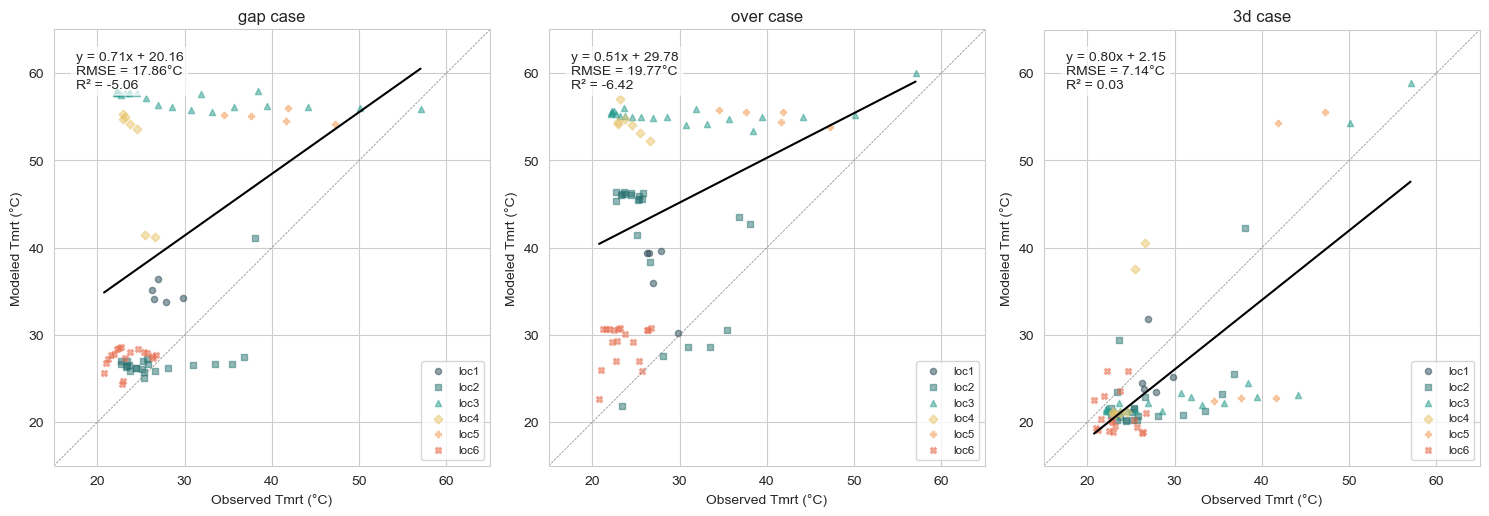

79


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new.csv"
]

# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['gap1', 'over1', '3d1']
obs_col = 'new_MRT_C'

# Define the boolean condition column
condition_col = 'under'

# Filter the data where the boolean column 'under' is True
df_clean = df[df[condition_col] == True][[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#264653", "#287271", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['o', 's', '^', 'D', 'P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 10))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(f"{model_col[:-1]} case")
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()
print(len(df_clean))

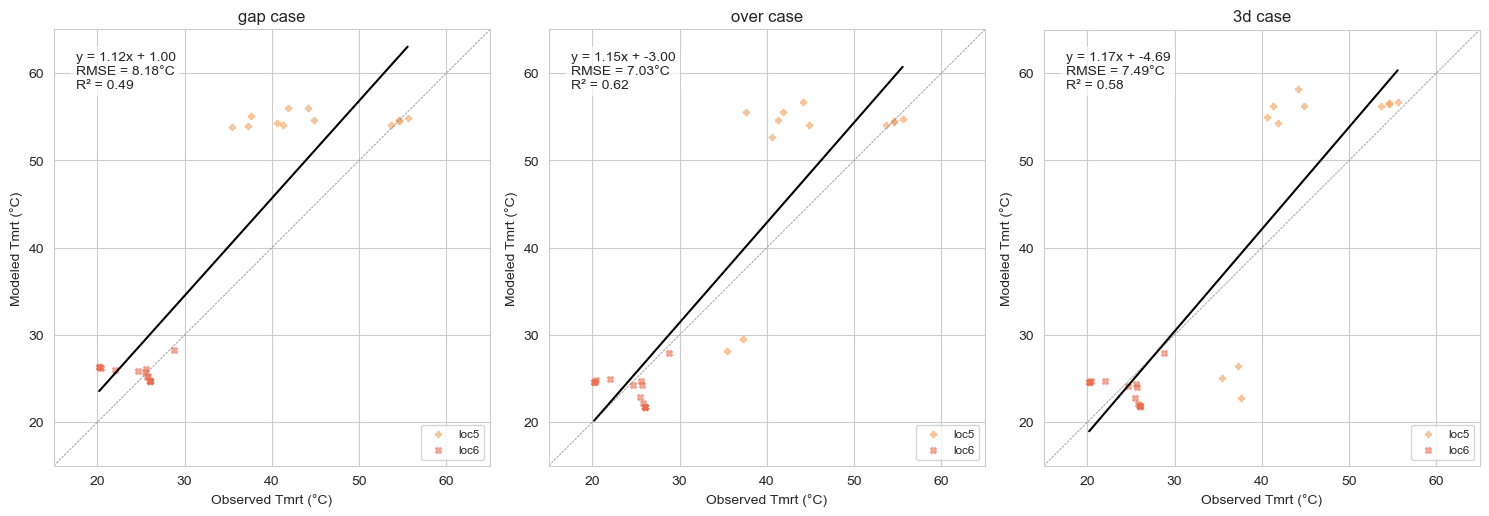

28


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_new2.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_new2.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_new2.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_new2.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_new2.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new2.csv"
]

# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['gap1', 'over1', '3d1']
obs_col = 'new_MRT_C'

# Define the boolean condition column
condition_col = 'cardinal_aligned'

# Filter the data where the boolean column 'under' is True
df_clean = df[df[condition_col] == True][[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 10))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(f"{model_col[:-1]} case")
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()
print(len(df_clean))

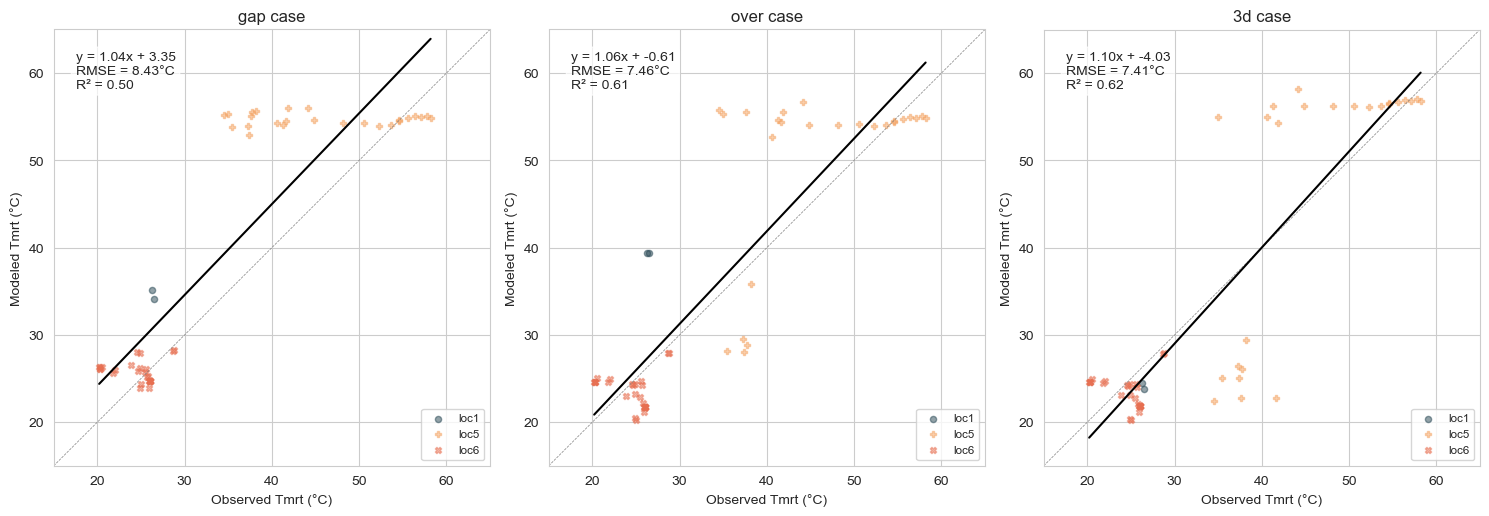

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new.csv"
]

# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['gap1', 'over1', '3d1']
obs_col = 'new_MRT_C'

# Define the boolean condition column
condition_col = 'cardinal_aligned_10'

# Filter the data where the boolean column 'under' is True
df_clean = df[df[condition_col] == True][[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#264653", "#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['o', 'P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 10))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(f"{model_col[:-1]} case")
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

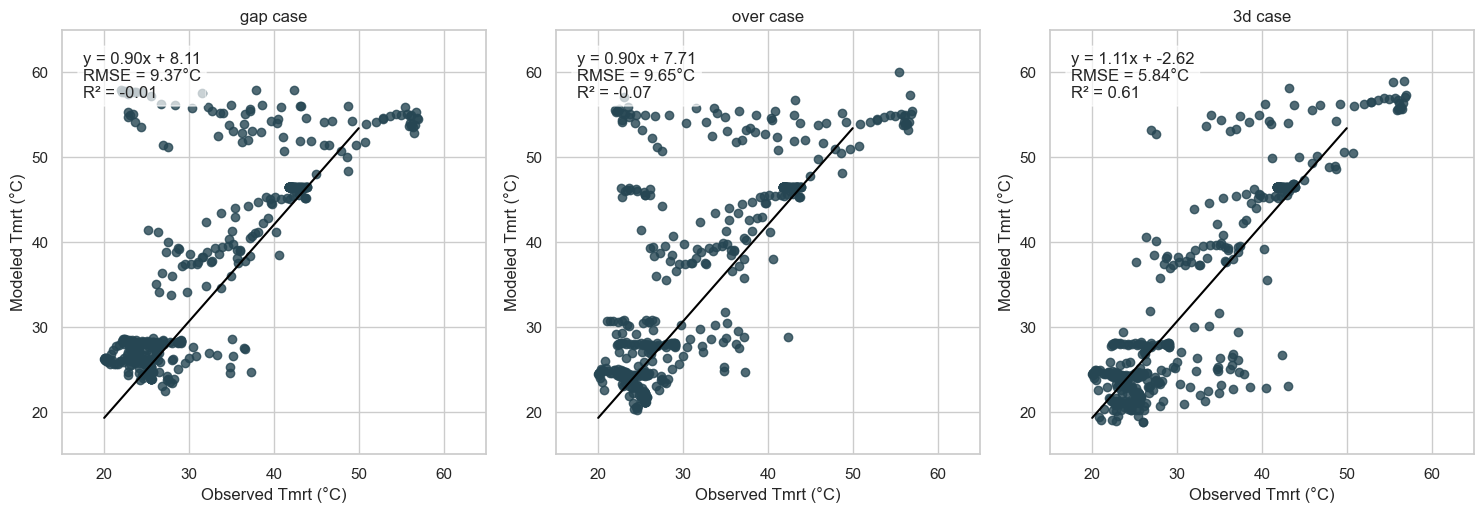

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new.csv"
]
# Read and concatenate all the CSV files into one DataFrame
df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

# Choose model columns to compare
model_cols = ['gap1', 'over1', '3d1']
obs_col = 'new_MRT_C'

# Clean the data (no filtering, just remove rows with missing values)
df_clean = df[[obs_col] + model_cols].dropna()

# Plot for each model
plt.figure(figsize=(15, 10))

plotmin = 15
plotmax = 65
for i, model_col in enumerate(model_cols, start=1):
    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_


    # Subplot
    ax = plt.subplot(1, len(model_cols), i)
    ax.scatter(df_clean[obs_col], df_clean[model_col], alpha=0.8)
    ax.plot(x_vals, y_vals, color='black')

    # Fit line range: based on actual data
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect fit line (always covering whole plot range)
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect

    # Text box with formula, RMSE and R²
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and formatting
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(f"{model_col[:-1]} case")
    ax.grid(True)
    ax.set_aspect('equal', 'box')
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])

plt.tight_layout()
plt.show()

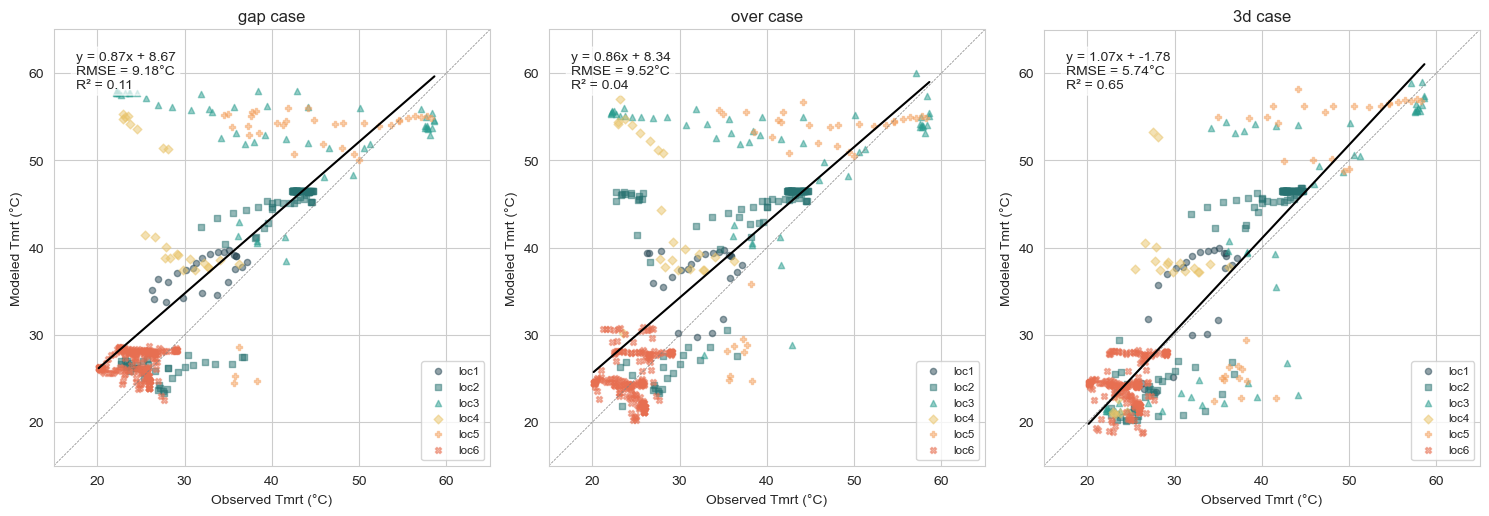

449


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import colormaps
import matplotlib.colors as mcolors
import seaborn as sns

# File paths of the 6 CSV files
file_paths = [
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc1_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc2_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc3_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc4_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc5_new.csv",
    "D:/Geomatics/thesis/_solweigcomparison/comparisonpoints/loc6_new.csv"
]
# Add source label to each DataFrame before concatenation
df_list = []
for i, file in enumerate(file_paths, start=1):
    df_temp = pd.read_csv(file)
    df_temp['source'] = f'loc{i}'
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Model columns and observed column
model_cols = ['gap1', 'over1', '3d1']
obs_col = 'new_MRT_C'

# Only keep necessary columns and drop rows with missing values
df_clean = df[[obs_col, 'source'] + model_cols].dropna()

# Color and marker mapping for sources
palette = ["#264653", "#287271", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
colors = palette
markers = ['o', 's', '^', 'D', 'P', 'X']
sources = sorted(df_clean['source'].unique())
source_styles = {src: {'color': c, 'marker': m} for src, c, m in zip(sources, colors, markers)}

# Plot setup
plt.figure(figsize=(15, 10))
plotmin, plotmax = 15, 65

for i, model_col in enumerate(model_cols, start=1):
    ax = plt.subplot(1, len(model_cols), i)

    # Linear regression
    reg = LinearRegression()
    reg.fit(df_clean[[obs_col]], df_clean[model_col])
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Regression line based on data range
    x_fit = np.linspace(df_clean[obs_col].min(), df_clean[obs_col].max(), 100)
    y_fit = slope * x_fit + intercept

    # Perfect line (y = x) across whole plot
    x_perfect = np.array([plotmin, plotmax])
    y_perfect = x_perfect
    ax.plot(x_perfect, y_perfect, color='gray', linestyle='--',  linewidth=0.5)

    # Regression line
    ax.plot(x_fit, y_fit, color='black')

    # Scatter points by source
    for src in sources:
        subset = df_clean[df_clean['source'] == src]
        ax.scatter(subset[obs_col], subset[model_col],
                   label=src,
                   alpha=0.5,
                   color= source_styles[src]['color'],
                   marker=source_styles[src]['marker'],
                   s=20)

    # Metrics
    rmse = np.sqrt(mean_squared_error(df_clean[obs_col], df_clean[model_col]))
    r2 = r2_score(df_clean[obs_col], df_clean[model_col])
    ax.text(0.05, 0.95,
            f"y = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}°C\nR² = {r2:.2f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and aesthetics
    ax.set_xlabel("Observed Tmrt (\N{DEGREE SIGN}C)")
    ax.set_ylabel("Modeled Tmrt (\N{DEGREE SIGN}C)")
    ax.set_title(f"{model_col[:-1]} case")
    ax.set_xlim([plotmin, plotmax])
    ax.set_ylim([plotmin, plotmax])
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()
print(len(df_clean))